In [81]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from typing import Literal,TypedDict,Annotated
load_dotenv()

True

In [82]:
essay=f"""
Artificial Intelligence (AI) is one of the most powerfull technology that is shaping the future of India. It help computers to think, learn and make decision like humans. In a developing country like India, AI is not only a advanced technology but also a need for solving many social and economic problems.

In India AI is being used in many sectors. In agriculture, AI based systems helps farmers to predict weather, identify crop disease and manage irrigation properly. Since most of the Indian population depend on farming, this technology is very usefull. With the help of satellite data and smart tools, farmers can increase there productivity and reduce losses.

Healthcare is another area where AI is growing very fast. AI is used for detecting diseases early, analysing medical images and helping doctors in treatment. In rural areas, were doctors are not easily available, AI based telemedicine is very helpful. During pandemics, AI helps goverment to track spread of diseases and manage hospitals resources.

Education sector in India is also changing because of AI. Online learning platforms uses AI to provide personalise learning to students. This helps students who learn slow or fast at different pace. AI based tools like virtual teachers and automatic evaluation system makes education more accesible, specially in remote areas.

Indian goverment is also promoting AI for better governance. AI is used in smart cities, traffic control, crime detection and public welfare schemes. These systems helps in reducing human errors and improve transparency. However, there are some challenges also.

One major problem of AI is job loss due to automation. Many workers fear that machines will replace there jobs. There are also issues related to data privacy and unethical use of AI. Many people in rural India still do not have digital skills, which can increase inequality.

In conclusion, AI has a huge potential to transform India. If it is used carefully and responsibly, it can solve many problems and improve quality of life. India has a young population and strong IT sector, so it can become a global leader in AI in coming years.


"""

In [83]:
model=ChatOpenAI(model='gpt-4o-mini')

In [84]:
class ScoreFeedback(BaseModel):
    feedback:Annotated[str,Field(description="Give qualitative feedback under 100 words")]
    score:Annotated[int,Field(ge=1,le=10)]

class COT(ScoreFeedback):
    pass

class Language(ScoreFeedback):
    pass
    
class Analysis(ScoreFeedback):
    pass

class Evaluation(TypedDict):
    essay:str
    clarity_of_thought: COT
    language: Language
    analysis: Analysis
    summary: ScoreFeedback




In [85]:
cot_model=model.with_structured_output(COT)

def getCot(state:Evaluation)->dict:
    prompt=f"""
Give feedback for Clarity of Thought {essay}
"""
    result=cot_model.invoke(prompt)

    return {
        'clarity_of_thought':result
    }
    

In [86]:
Language_model=model.with_structured_output(Language)

def getLanguage(state:Evaluation)->dict:
    prompt=f"""
Give feedback for Language {essay}
"""
    result=Language_model.invoke(prompt)

    return {
        'language':result
    }
    

In [87]:
analysis_model=model.with_structured_output(Analysis)

def getAnalysis(state:Evaluation)->dict:
    prompt=f"""
Give feedback for Language {essay}
"""
    result=analysis_model.invoke(prompt)

    return {
        'analysis':result
    }
    

In [88]:
summary_model=model.with_structured_output(ScoreFeedback)

def getSummary(state:Evaluation)->dict:
    prompt=f"""
Give feedback {state['clarity_of_thought']}, {state['analysis']}, {state['language']}
"""
    result=summary_model.invoke(prompt)

    return {
        'summary':result
    }
    

In [89]:
graph=StateGraph(Evaluation)

graph.add_node('getCot',getCot)
graph.add_node('getLanguage',getLanguage)
graph.add_node('getAnalysis',getAnalysis)
graph.add_node('getSummary',getSummary)

graph.add_edge(START,'getCot')
graph.add_edge(START,'getLanguage')
graph.add_edge(START,'getAnalysis')

graph.add_edge('getCot','getSummary')
graph.add_edge('getLanguage','getSummary')
graph.add_edge('getAnalysis','getSummary')
graph.add_edge('getSummary',END)

workflow=graph.compile()

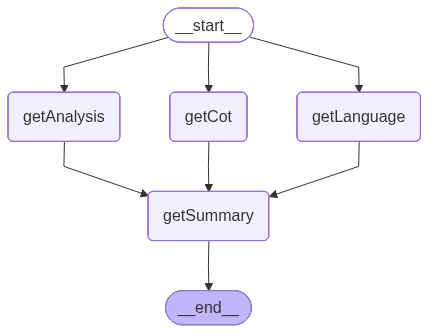

In [90]:
workflow

In [91]:
initial_state={
    'essay':essay
}

final_state=workflow.invoke(initial_state)

In [92]:
print(final_state['summary'])

feedback="The analysis of AI's impact across sectors in India is commendable, with clear examples illustrating its benefits. However, grammatical errors, including typos like 'powerfull' and 'goverment,' hinder the professionalism of the writing. Sentences could be more concise and better structured for improved clarity and flow. To create a more balanced narrative, consider discussing both the advantages and challenges posed by AI. Overall, a well-structured piece with good content that requires some revision to enhance quality." score=7


In [93]:
print(final_state['analysis'].feedback)

The text provides a clear overview of AI's impact on different sectors in India, but it contains several grammatical errors and typos (e.g., "powerfull," "usefull," "there," "goverment," "were") that detract from the professional quality of the writing. Additionally, some sentences are overly long and would benefit from better structuring for clarity. The use of examples is strong, showcasing AI's applications well, but a more cohesive flow and refined language would enhance readability and engagement.


In [94]:
print(final_state['clarity_of_thought'])

feedback='The clarity of thought in this piece is generally good, effectively highlighting the various applications of AI in India, such as agriculture, healthcare, education, and governance. Each point is clearly articulated, providing specific examples that support the claims. However, some grammatical errors and informal phrases detract from the overall clarity, such as "powerfull" (should be powerful) and "there" (should be their). More structured paragraphs, particularly separating challenges from applications, would enhance readability and organization. Overall, the message is coherent but could benefit from minor revisions for precision and clarity.' score=7
